In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from ast import literal_eval
from tqdm import tqdm

In [5]:
tqdm.pandas()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
songs = pd.read_csv('./data/five_g_500_modeling.csv')

In [7]:
features = songs.columns[22:].drop([])

In [8]:
X = songs[features]
y = songs['genre']

In [9]:
def running_models(X, y, scaled=False, c=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # MODELING WITH SCALED FEATURES #
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model_sc = SVC(C=c, kernel='rbf', degree=3)
    model_sc.fit(X_train_sc, y_train)
    train_score = model_sc.score(X_train_sc, y_train)
    test_score = model_sc.score(X_test_sc, y_test)
    
    row = {'model': type(model_sc).__name__,
           'train_score' : train_score,
          'test_score' : test_score,
           'C': c,
          'scaled': True}
    model_df = model_df.append(row, ignore_index=True)
    
    # MODELING WITH UNSCALED FEATURES #
    
    model = SVC(C=c, kernel='rbf', degree=3)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
       'train_score' : train_score,
      'test_score' : test_score,
       'C': c,
      'scaled': False}
    model_df = model_df.append(row, ignore_index=True)
    return model_df

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [10]:
running_models(X, y)

,train_score,test_score,C,model,scaled
0,0.957867,0.8272,10.0,SVC,1.0
1,0.820267,0.8416,10.0,SVC,0.0


In [523]:
# Create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

# Scale the features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [524]:
model = SVC(C=.35)
model.fit(X_train_sc, y_train)

SVC(C=0.35)

In [525]:
categories = list(set(y_preds))
numbers = list(range(5))

In [526]:
y_preds = model.predict(X_test_sc)

In [527]:
results = X_test.copy()

In [529]:
results.loc[:, 'genre'] = y_test.copy()

In [530]:
results.loc[:, 'preds'] = y_preds.copy()

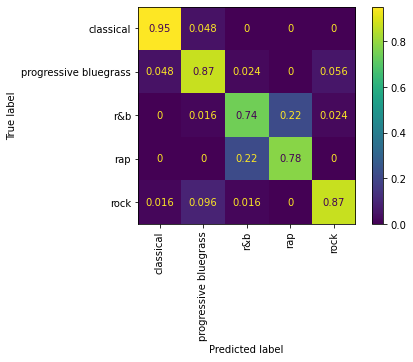

In [531]:
plot_confusion_matrix(model, X_test_sc, y_test, xticks_rotation='vertical', normalize='true');

We can see here that our model performs **best on classical music**, and performs **worst on r&b, only predicting correctly 74% of the time.** I want to dig more into why that is

In [532]:
results_wrong = results[results['genre'] != results['preds']]

In [533]:
songs_wrong = songs.loc[results_wrong.index, ['track_name']]

In [534]:
results_wrong['track_name'] = songs_wrong

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [535]:
results_wrong[(results_wrong['preds'] == 'r&b') & (results_wrong['genre'] == 'rap')].head()

,mean_energy,std_energy,min_energy,max_energy,max_rms,std_rms,median_rms,min_rms,mfcc_mean_00,mfcc_mean_01,...,mfcc_min_05,mfcc_min_06,mfcc_min_07,mfcc_min_08,mfcc_min_09,mfcc_min_10,mfcc_min_11,genre,preds,track_name
1653,26.837427,29.822205,0.227380,231.272377,0.672089,0.110432,0.177969,0.021074,-132.137619,106.776787,...,-12.309896,-47.899212,-35.528416,-38.607246,-34.404018,-37.107895,-35.714878,rap,r&b,Only You (feat. The Notorious B.I.G. & Mase) -...
1778,46.566456,41.379618,0.605496,280.619677,0.740328,0.110651,0.267670,0.034389,-109.434654,109.749611,...,-4.021262,-65.765266,-25.861614,-27.706072,-78.043472,-24.386654,-23.708405,rap,r&b,Somethin Tells Me
1856,39.402694,30.653769,2.283467,236.971450,0.680320,0.092538,0.251618,0.066782,-85.101601,125.324379,...,-11.752495,-47.426876,-22.385229,-40.177628,-33.128696,-28.820669,-27.308964,rap,r&b,Sky's the Limit (feat. 112) - 2014 Remaster
1673,42.095754,27.215504,0.074239,172.595618,0.580604,0.101780,0.283009,0.012042,-77.639091,128.701294,...,-22.018921,-56.880360,-39.439629,-40.098961,-32.648499,-37.144257,-33.395630,rap,r&b,Whatever You Like
1538,45.313658,61.220352,0.203308,384.215485,0.866268,0.150881,0.250395,0.019927,-146.169693,117.854248,...,-23.983143,-59.268829,-26.802391,-56.876747,-33.827942,-16.999588,-41.450058,rap,r&b,Can't Believe It (feat. Lil' Wayne)


In [536]:
group_preds = results_wrong.groupby('preds').mean()

In [537]:
# Getting columns where rap and r&b are very close to each other
group_preds.columns[abs(group_preds.loc['rap']) - abs(group_preds.loc['r&b']) < 0.001]

Index(['min_rms', 'mfcc_mean_01', 'mfcc_mean_02', 'mfcc_mean_03',
       'mfcc_mean_04', 'mfcc_mean_06', 'mfcc_mean_07', 'mfcc_mean_08',
       'mfcc_mean_09', 'mfcc_min_06', 'mfcc_min_08'],
      dtype='object')

In [516]:
results_wrong['genre'].value_counts(normalize=True)

r&b                      0.333333
rap                      0.254902
progressive bluegrass    0.186275
rock                     0.166667
classical                0.058824
Name: genre, dtype: float64

Rap and R&B seem to be predicted wrong most often with these new features I've pulled

In [517]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

r&b    1.0
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as r&b.

In [518]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

rap                      0.852941
rock                     0.088235
progressive bluegrass    0.058824
Name: preds, dtype: float64

When R&B is predicted wrong, it's predicted to be rap 84% of the time

In [237]:
genre_mean = songs.groupby('genre').mean()

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time.

In [241]:
X = songs[features]
# Thanks joris on SO: https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
y_cat = songs['genre'].astype('category').cat.codes

In [242]:
y = to_categorical(y_cat)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [244]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [299]:
fnn_model = Sequential()

fnn_model.add(Dense(16, activation='relu', input_shape=(X_train_sc.shape[1],)))
fnn_model.add(Dense(64, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(16, activation='relu'))
fnn_model.add(Dense(5, activation='softmax'))

fnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

hist = fnn_model.fit(X_train_sc, y_train,
                epochs=100,
                batch_size=128,
                validation_data=(X_test_sc, y_test),
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/100
15/15 [==============================] - 0s 7ms/step - loss: 1.5583 - acc: 0.2448 - val_loss: 1.4482 - val_acc: 0.4304
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 1.3683 - acc: 0.4475 - val_loss: 1.2088 - val_acc: 0.5952
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1525 - acc: 0.5424 - val_loss: 0.9566 - val_acc: 0.6800
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.9417 - acc: 0.6347 - val_loss: 0.7834 - val_acc: 0.7024
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.8217 - acc: 0.6560 - val_loss: 0.6928 - val_acc: 0.6976
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.7537 - acc: 0.6843 - val_loss: 0.6420 - val_acc: 0.7264
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6976 - acc: 0.7029 - val_loss: 0.6025 - val_acc: 0.7344
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6543 - a

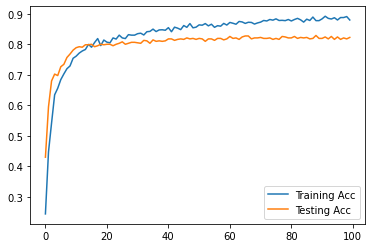

In [300]:
plt.plot(hist.history['acc'], label="Training Acc")
plt.plot(hist.history['val_acc'], label="Testing Acc")
plt.legend();

With my extracted features (energy, rms, and mfcc), I'm able to improve on the accuracy of the spotify model by **5-7% on training data**
* SVC model $\approx 84\%$ accuracy
* FNN model $\approx 82\%$ accuracy

## What's next?

I still want to find some way for the model to be able to tell the difference between rap and r&b